<a href="https://colab.research.google.com/github/doo52oh/Dacon/blob/main/predict_stockprice/stock_list_w4_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.주제



KOSPI-200과 KOSDAQ-200의 주어진 기간에 마지막으로 거래된 가격(종가)를 예측하는 경진대회입니다.





## 2.주식 종료 가격 예측 Pre Competition 설명



안녕하세요, 데이커(가칭) 여러분 🤗 (설문조사 링크 : https://dacon.io/forum/404044)

데이커와 함께 만드는 첫 Pre Competition입니다!



주식의 종료 가격을 예측은 도전적인 분야입니다.

따라서 정식 대회로 운영하게 되면 다양한 시행착오가 예상됩니다.

따라서 이번 대회는 데이커와 함께 만들려 합니다. 🥳



"주식 종료 가격 예측 Pre Competition"과 관련해 여러분의 자유로운 의견을 "토크 게시판 [필독]글"에 남겨주세요!

여러분들의 제시한 의견으로 대회가 더 합리적으로 만들고자 합니다.



7월 28일의 KOSPI-200과 KOSDAQ-200에 해당하는 종목들의 종료가격을 예측하는 모델을 만들어 주세요!

대회 중에 데이커 여러분들의 의견을 수렴해, 이후에 정식 대회로 찾아뵙겠습니다!



※ 여러가지 의문점들과 의견들을 토크 게시판에 올려주세요


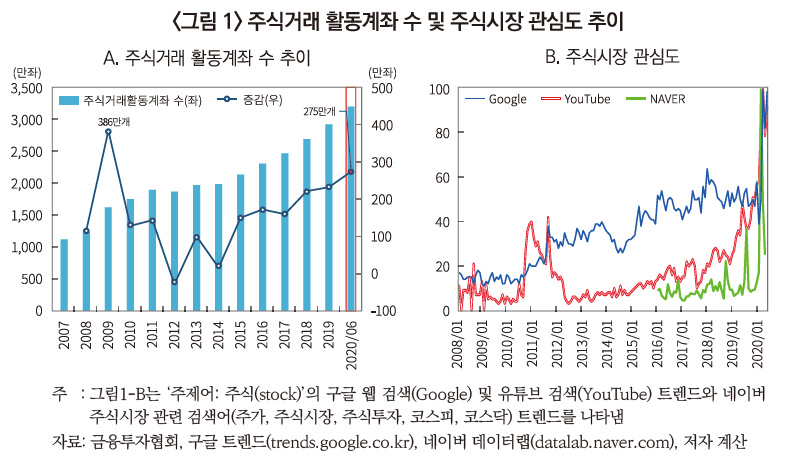


## 3.대회 배경



코로나19 대유행으로 변동성이 높아져 주식 투자에 관심이 많습니다.



주식시장이 급락했던 3월 주식거래 활동계좌1)는 3천만 계좌를 돌파했고2), 올해 6월까지(6/24 기준) 약 275만 개의 활동계좌가 늘어나 2009년 이후 신규 투자자가 가장 많이 유입됐다. 

또한 국내 상위 검색포털의 주식시장 관련 검색이 급격하게 늘어나는 등 사람들 사이에서 주식투자가 유행하고 있는 것으로 보인다. (<그림 1> 참고)



"코로나19 위기와 최근 주식투자 수요 증가에 대한 소고" 자본시장연구원 자료



국립중앙도서관에서 발표한 3년간 금융 관련 도서 대출 현황에 의하면 2018년 상위 50위 도서 중 6권이 주식관련 도서였습니다.

COVID-19 이후에는 14권으로, 2배 이상 증가했습니다.

(국립중앙도서관, “공공도서관 금융 관련 도서 대출 현황 결과 발표”, 2021-04-23)



또한 최근 암호화폐 시장에서 다시 국내 주식 시장으로 모이는 분위기라고 합니다.

(강창욱, “코인에서 주식시장으로 투자자 돈 다시 몰린다”, 국민일보, 2021-06-07)



이런 상황 속에서, 주식의 종료 가격을 정확하게 예측할 수 있다면 어떨까요?

지금까지 실행된 다양한 시계열 대회를 참고해 자신만의 모델을 만들어 보세요!





## 4. 주최 / 주관



주최 : DACON

주관 : DACON

In [81]:
! pip install finance-datareader

In [82]:
import pandas as pd
import numpy as np
import os
import FinanceDataReader as fdr # 가격 확인을 위하여 라이브러리
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [83]:
# read stock code, list

# path = './open'
list_name = 'Stock_List.csv'
sample_name = 'sample_submission_week4.csv'

# stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list = pd.read_csv(list_name)
sample_submission = pd.read_csv(sample_name)

#  종목코드 자리수 균일화
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
371,더네이쳐홀딩스,298540,KOSDAQ
372,코엔텍,029960,KOSDAQ
373,원익홀딩스,030530,KOSDAQ
374,웹케시,053580,KOSDAQ


In [84]:
stock_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   종목명     376 non-null    object
 1   종목코드    376 non-null    object
 2   상장시장    376 non-null    object
dtypes: object(3)
memory usage: 8.9+ KB


## Get Data & Modeling

In [85]:
# 학습 대상 날짜 설정 및 정보 파악

start_date = '20210104'
end_date = '20211001'

start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime('%V')
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date'])

print(f'WEEKDAY of "start_date" : {start_weekday}')
print(f'NUM of WEEKS to "end_date" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {Business_days.shape}', )
display(Business_days.tail())

WEEKDAY of "start_date" : 0
NUM of WEEKS to "end_date" : 39
HOW MANY "Business_days" : (195, 1)


,Date
190,2021-09-27
191,2021-09-28
192,2021-09-29
193,2021-09-30
194,2021-10-01


In [86]:
comp_code =  stock_list['종목코드'].values
comp_code = sorted(comp_code)

print(comp_code)

# # 지정한 날짜에 해당하는 주식 데이터를 종목코드와 FinanceDataReader 라이브러리를 사용하여 로드
# data = fdr.DataReader(comp_code, start = start_date, end = end_date)[['Close']].reset_index()
# data.tail()

['000060', '000080', '000100', '000120', '000150', '000240', '000250', '000270', '000660', '000670', '000720', '000810', '000880', '000990', '001230', '001440', '001450', '001740', '002380', '002790', '003000', '003090', '003380', '003410', '003490', '003670', '003800', '004000', '004020', '004170', '004370', '004490', '004800', '004990', '005250', '005290', '005300', '005380', '005385', '005387', '005490', '005830', '005850', '005930', '005935', '005940', '006260', '006280', '006360', '006400', '006650', '006730', '006800', '007070', '007310', '007390', '008560', '008770', '008930', '009150', '009240', '009540', '009830', '009900', '010060', '010120', '010130', '010620', '010780', '010950', '011000', '011070', '011170', '011200', '011210', '011780', '012330', '012450', '012510', '012750', '013120', '013890', '014680', '015750', '015760', '016360', '016380', '017670', '017800', '018260', '018880', '019170', '020150', '021240', '022100', '023530', '024110', '025900', '025980', '026960',

In [87]:
# 지정한 날짜에 해당하는 주식 데이터를 종목코드와 FinanceDataReader 라이브러리를 사용하여 로드6
for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start = start_date, end = end_date).reset_index()

data.tail()

100%|██████████| 376/376 [02:46<00:00,  2.26it/s]


,Date,Open,High,Low,Close,Volume,Change
174,2021-09-13,83400,87300,82700,83800,210650,-0.007109
175,2021-09-14,85100,88500,84600,85600,198800,0.021480
176,2021-09-15,87000,88400,83200,83700,177217,-0.022196
177,2021-09-16,84200,85400,83300,83900,119279,0.002389
178,2021-09-17,84900,84900,80700,81000,165152,-0.034565


In [88]:
# 모델 성능 평가를 위한 test set
train_test = data[-5:]
train_test

,Date,Open,High,Low,Close,Volume,Change
174,2021-09-13,83400,87300,82700,83800,210650,-0.007109
175,2021-09-14,85100,88500,84600,85600,198800,0.021480
176,2021-09-15,87000,88400,83200,83700,177217,-0.022196
177,2021-09-16,84200,85400,83300,83900,119279,0.002389
178,2021-09-17,84900,84900,80700,81000,165152,-0.034565


In [89]:
# 이동평균 값 추가
ma5 = data['Close'].rolling(window=5).mean()
data['MA5'] = ma5
data = data.fillna(0) #첫 네개의 값은 이동평균값이 없으므로 결측값으로 나오는데, 이를 0으로 채운다
data

,Date,Open,High,Low,Close,Volume,Change,MA5
0,2021-01-04,49800,49850,48100,49100,208127,0.028272,0.0
1,2021-01-05,49000,49000,47200,47900,171744,-0.024440,0.0
2,2021-01-06,47950,48450,46600,47350,125772,-0.011482,0.0
3,2021-01-07,47700,48750,47200,48500,128374,0.024287,0.0
4,2021-01-08,49000,52000,48000,51000,513980,0.051546,48770.0
...,...,...,...,...,...,...,...,...
174,2021-09-13,83400,87300,82700,83800,210650,-0.007109,86560.0
175,2021-09-14,85100,88500,84600,85600,198800,0.021480,85920.0
176,2021-09-15,87000,88400,83200,83700,177217,-0.022196,85160.0
177,2021-09-16,84200,85400,83300,83900,119279,0.002389,84280.0


## 외부데이터 수집

In [90]:
# 추후 

## 상관분석 및 추세 시각화

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# plt.figure(figsize=(12,10))
# sns.heatmap(df_scaled.corr(),annot=True)

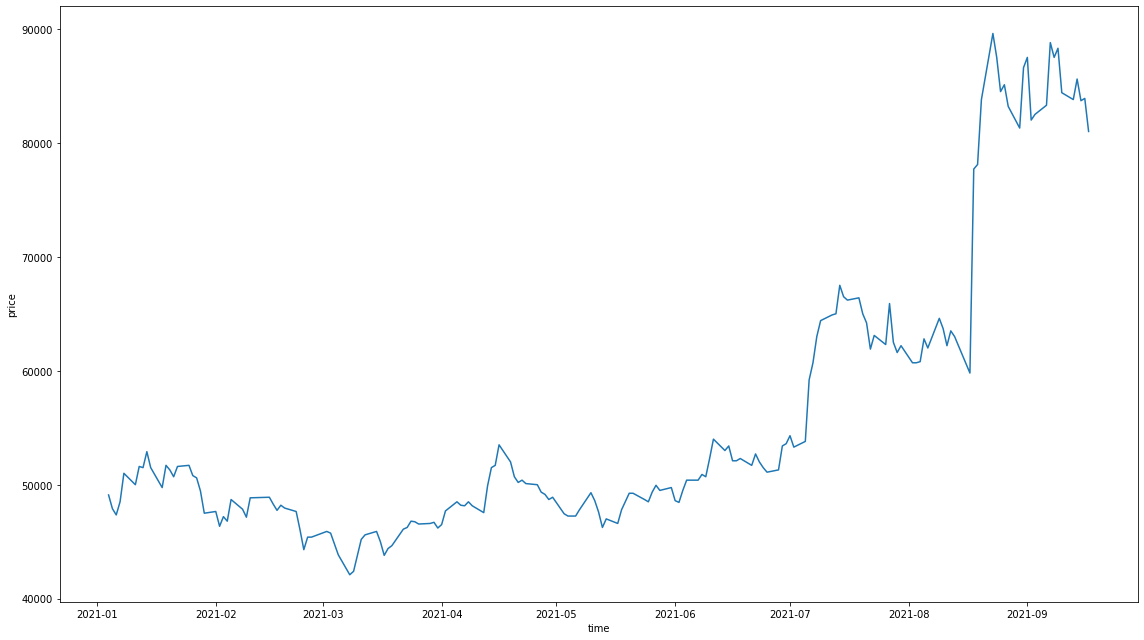

In [92]:
plt.figure(figsize = (16,9))
sns.lineplot(y=data.loc[:,'Close'], x=data.loc[:,'Date'])
plt.xlabel('time')
plt.ylabel('price')
plt.tight_layout()
plt.show()

In [93]:
df = pd.merge(Business_days, data, how='outer')
df['weekday'] = df.Date.apply(lambda x : x.weekday())
df['weeknum'] = df.Date.apply(lambda x : x.strftime('%V'))
df.Close = df.Close.ffill()
# df = pd.pivot_table(data = df, values = ['Close','High','Low','Open'], columns = 'weekday', index = 'weeknum')
# df = pd.pivot_table(data = df, values = ['Close','High','MA5','Low','n_high','n_close'], columns = 'weekday', index = 'weeknum')
df = pd.pivot_table(data = df, values = ['Close','High','MA5','Volume'], columns = 'weekday', index = 'weeknum')
df.head()

Close                    ...    Volume                    
weekday        0        1        2  ...         2         3         4
weeknum                             ...                              
01       49100.0  47900.0  47350.0  ...  125772.0  128374.0  513980.0
02       50000.0  51600.0  51500.0  ...   96176.0  121413.0   99601.0
03       49750.0  51700.0  51300.0  ...  115870.0   71448.0  139506.0
04       51700.0  50800.0  50600.0  ...   78458.0   85443.0  109185.0
05       47650.0  46350.0  47200.0  ...   62596.0   52654.0   82195.0

[5 rows x 20 columns]

In [94]:
df.tail()

Close                    ...    Volume                    
weekday        0        1        2  ...         2         3         4
weeknum                             ...                              
35       81300.0  86600.0  87500.0  ...  156850.0  198717.0  110044.0
36       83300.0  88800.0  87500.0  ...  420401.0  300248.0  222137.0
37       83800.0  85600.0  83700.0  ...  177217.0  119279.0  165152.0
38       81000.0  81000.0  81000.0  ...       NaN       NaN       NaN
39       81000.0  81000.0  81000.0  ...       NaN       NaN       NaN

[5 rows x 20 columns]

In [95]:
df.isna().sum()

        weekday
Close   0          0
        1          0
        2          0
        3          0
        4          0
High    0          4
        1          2
        2          4
        3          3
        4          3
MA5     0          4
        1          2
        2          4
        3          3
        4          3
Volume  0          4
        1          2
        2          4
        3          3
        4          3
dtype: int64

In [96]:
df[:]['High'][0].fillna(df[:]['High'][0].median(),inplace=True) # inplace=True로 결측치 치환 반영
df[:]['High'][1].fillna(df[:]['High'][1].median(),inplace=True)
df[:]['High'][2].fillna(df[:]['High'][2].median(),inplace=True)
df[:]['High'][3].fillna(df[:]['High'][3].median(),inplace=True)
df[:]['High'][4].fillna(df[:]['High'][4].median(),inplace=True)

df[:]['Volume'][0].fillna(df[:]['Volume'][0].median(),inplace=True) # inplace=True로 결측치 치환 반영
df[:]['Volume'][1].fillna(df[:]['Volume'][1].median(),inplace=True)
df[:]['Volume'][2].fillna(df[:]['Volume'][2].median(),inplace=True)
df[:]['Volume'][3].fillna(df[:]['Volume'][3].median(),inplace=True)
df[:]['Volume'][4].fillna(df[:]['Volume'][4].median(),inplace=True)

df[:]['MA5'][0].fillna(df[:]['MA5'][0].median(),inplace=True) # inplace=True로 결측치 치환 반영
df[:]['MA5'][1].fillna(df[:]['MA5'][1].median(),inplace=True)
df[:]['MA5'][2].fillna(df[:]['MA5'][2].median(),inplace=True)
df[:]['MA5'][3].fillna(df[:]['MA5'][3].median(),inplace=True)
df[:]['MA5'][4].fillna(df[:]['MA5'][4].median(),inplace=True)

# df[:]['n_high'][0].fillna(df[:]['n_high'][0].median(),inplace=True) # inplace=True로 결측치 치환 반영
# df[:]['n_high'][2].fillna(df[:]['n_high'][2].median(),inplace=True)
# df[:]['n_high'][3].fillna(df[:]['n_high'][3].median(),inplace=True)
# df[:]['n_high'][4].fillna(df[:]['n_high'][4].median(),inplace=True)

# df[:]['n_close'][0].fillna(df[:]['n_close'][0].median(),inplace=True) # inplace=True로 결측치 치환 반영
# df[:]['n_close'][2].fillna(df[:]['n_close'][2].median(),inplace=True)
# df[:]['n_close'][3].fillna(df[:]['n_close'][3].median(),inplace=True)
# df[:]['n_close'][4].fillna(df[:]['n_close'][4].median(),inplace=True)

In [97]:
df.isna().sum()

        weekday
Close   0          0
        1          0
        2          0
        3          0
        4          0
High    0          0
        1          0
        2          0
        3          0
        4          0
MA5     0          0
        1          0
        2          0
        3          0
        4          0
Volume  0          0
        1          0
        2          0
        3          0
        4          0
dtype: int64

# LR


In [98]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,SGDRegressor

In [99]:
model = LinearRegression()
x = df.iloc[0:-2].to_numpy() # 0 to -2까지의 데이터로 학습을 하여서

y = df.iloc[1:-1]['Close'].to_numpy() # 1 to -1까지의 데이터르 예측하는 과정을 수행
# 우리의 예측 대상은 월,화,수,목,금 5개의 feature이다.
y_0 = y[:,0] # 월요일
y_1 = y[:,1] # 화요일
y_2 = y[:,2] # 수요일
y_3 = y[:,3] # 목요일
y_4 = y[:,4] # 금요일

y_values = [y_0, y_1, y_2, y_3, y_4]

print(x.shape)
print(y_0.shape)
##################################
x_public = df.iloc[-2].to_numpy()

predicitions = []
for y_value in y_values:
    model.fit(x,y_value)
    prediction = model.predict(np.expand_dims(x_public,0)) # 차원 추가
    predicitions.append(prediction[0])
    
print('-'*10)
print(predicitions)

y_public = df.iloc[-1]['Close'].values

from sklearn.metrics import mean_squared_log_error
print(mean_squared_log_error(predicitions, y_public))

(37, 20)
(37,)
----------
[65258.15603068582, 49292.269067280504, 194840.16797849658, 211511.3434840091, 274238.2177416074]
0.6944628428323595


In [100]:
# sample_submission = sample_submission[['Day']]
# sample_submission['Day'] =pd.to_datetime(sample_submission['Day'])

In [101]:
for code in tqdm(stock_list['종목코드'].values):

    # data load
    data = fdr.DataReader(code, start = start_date, end = end_date).reset_index()
    # 이동평균 값 추가
    ma5 = data['Close'].rolling(window=5).mean()
    data['MA5'] = ma5
    data = data.fillna(0) #첫 네개의 값은 이동평균값이 없으므로 결측값으로 나오는데, 이를 0으로 채운다

    # scaling
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scale_cols = ['Open','High','Low','Close','Volume','Change','MA5']
    sc = scaler.fit(data[scale_cols])
    df_scaled = sc.transform(data[scale_cols])
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = scale_cols
    
    scaler2 = MinMaxScaler()
    scale_cols2 = ['Close']
    sc2 = scaler2.fit(data[scale_cols2])
    df_scaled_2 = sc2.transform(data[scale_cols2])
    df_scaled_2 = pd.DataFrame(df_scaled_2)
    df_scaled_2.columns = scale_cols2
    
    df_scaled['Date']=data['Date']
    df_scaled['Close'] = df_scaled_2['Close']
    
    # make pivot table
    data = pd.merge(Business_days, df_scaled, how = 'outer')
    data['weekday'] = data.Date.apply(lambda x : x.weekday())
    data['weeknum'] = data.Date.apply(lambda x : x.strftime('%V'))
    data.Close = data.Close.ffill()
    data = pd.pivot_table(data = data, values = ['Close','High','MA5','Volume'], columns = 'weekday', index = 'weeknum')
    
    # nan value check
    if data.isna().sum().sum()>0:
        for i in range(5):
            data[:]['High'][i].fillna(data[:]['High'][i].median(),inplace=True) # inplace=True로 결측치 치환 반영
            data[:]['Volume'][i].fillna(data[:]['Volume'][i].median(),inplace=True)
            data[:]['Close'][i].fillna(data[:]['Close'][i].median(),inplace=True)
            data[:]['MA5'][i].fillna(data[:]['MA5'][i].median(),inplace=True)
              
    x = data.iloc[0:-2].to_numpy() # 2021년 1월 04일 ~ 2021년 9월 15일까지의 데이터로
    y = data.iloc[1:-1]['Close'].to_numpy() # 2021년 1월 05일 ~ 2021년 9월 16일까지의 데이터를 학습한다.
    y_0 = y[:,0]
    y_1 = y[:,1]
    y_2 = y[:,2]
    y_3 = y[:,3]
    y_4 = y[:,4]

    y_values = [y_0, y_1, y_2, y_3, y_4]
    x_public = data.iloc[-2].to_numpy() # 2021년 9월 16일의 데이터를 예측할 것이다.
    
    predictions = []
    for y_value in y_values :
        model.fit(x,y_value)
        prediction = model.predict(np.expand_dims(x_public,0))
        prediction = sc2.inverse_transform(prediction.reshape(-1,1))
        predictions.append(prediction[0])
#     print(predictions)
#     print(type(predictions[0]))

    sample_submission.loc[:,code] = predictions * 2
sample_submission.isna().sum().sum()

 26%|██▋       | 99/376 [00:51<01:58,  2.34it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
 62%|██████▏   | 234/376 [02:00<01:03,  2.24it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
100%|██████████| 376/376 [03:07<00:00,  2.01it/s]


0

In [102]:
sample_submission.columns

Index(['Day', '000060', '000080', '000100', '000120', '000150', '000240',
       '000250', '000270', '000660',
       ...
       '330860', '336260', '336370', '347860', '348150', '348210', '352820',
       '357780', '363280', '950130'],
      dtype='object', length=377)

In [103]:
columns = list(sample_submission.columns[1:])
columns = ['Day'] + [str(x).zfill(6) for x in columns]
sample_submission.columns = columns

In [104]:
sample_submission.columns

Index(['Day', '000060', '000080', '000100', '000120', '000150', '000240',
       '000250', '000270', '000660',
       ...
       '330860', '336260', '336370', '347860', '348150', '348210', '352820',
       '357780', '363280', '950130'],
      dtype='object', length=377)

In [105]:
sample_submission.to_csv('Linear_Week4.csv',index=False)

In [106]:
sample_submission 

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,000720,000810,000880,000990,001230,001440,001450,001740,002380,002790,003000,003090,003380,003410,003490,003670,003800,004000,004020,004170,004370,004490,004800,004990,005250,005290,005300,005380,005385,...,273130,278280,278530,282330,285130,287410,290510,290650,292150,293490,293780,294090,294870,298000,298020,298050,298380,298540,299030,299660,299900,307950,314130,316140,319400,319660,321550,323990,326030,330590,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-09-06,12087.396078,33326.308918,62978.996460,179910.155444,64180.802313,16836.319771,51306.475670,86948.068004,195898.843604,737821.528012,37231.459902,230628.865323,28127.024421,53861.921930,19787.394993,2773.631667,26333.645035,5414.194320,-1.556529e+05,79203.724950,22478.555908,34119.199599,9559.721803,8234.019076,27442.985503,153768.525449,50222.640063,89113.422528,50731.194728,267475.713706,287869.337555,88570.506284,92226.906221,36660.471796,30999.119235,33653.005863,145686.625705,175499.728008,93528.095491,...,109230.833429,2.366258e+05,14425.784622,209891.473405,246016.668771,1133.258850,8452.170299,36691.897247,11448.669489,-16693.548775,-126059.844064,49536.689151,30193.623717,529655.839760,763474.350039,-843347.561094,20128.772009,29241.299601,59806.228053,74035.117748,12199.346321,96530.382806,46733.425322,10984.696679,1058.622985,40871.394795,18635.820170,73010.996245,119132.587412,5542.359476,52403.316789,49836.289063,-63956.447686,33692.810698,28003.752302,59513.723079,276164.265367,291762.077818,28431.136290,7945.434783
1,2021-09-07,15864.537062,32095.267451,63537.719869,180595.110188,74765.287916,16545.158740,51041.535604,90968.943218,211086.198647,812576.514886,31544.999052,271006.795148,19925.206284,54554.469211,20340.419227,-1869.791368,26913.993665,5255.675415,-7.986069e+05,54518.392801,23702.030776,34024.993098,9595.871815,8167.263235,23246.252900,171192.252489,89147.237130,69745.992760,53574.106599,266902.443467,295362.667477,85772.856731,104437.827802,35903.171684,29601.919358,34595.728257,155276.008884,195187.646038,83938.660289,...,109161.933950,9.283697e+05,14186.303874,250026.174230,275097.127808,1290.865248,8645.941522,43074.466060,11727.393312,86343.752274,-140228.018105,67125.790977,27873.725534,548745.057336,779581.389962,-661777.420853,17341.560381,12638.072761,56804.076077,138953.454301,13682.924118,125014.450210,48231.864402,11249.774367,2966.586835,43149.009799,19433.948646,84174.005928,112706.874465,5572.904431,53043.115101,49363.450486,-21184.306909,35032.557952,31326.008683,64225.207671,280507.150608,263090.441067,27680.364818,10376.357211
2,2021-09-08,17311.930767,30046.035318,65621.941073,185266.409214,93357.450978,17751.260323,54597.695190,94855.481226,205522.807248,748499.314710,29732.092650,267478.789443,24207.070807,52141.826642,20086.397038,-1060.849415,27171.419277,4528.071909,-1.055336e+06,70255.892508,24181.340556,32595.789952,9626.745519,7396.733471,21385.782732,165928.670974,64649.011665,42900.085107,53002.038207,264666.736053,297504.070855,85212.888108,95205.592262,35434.413465,29282.528520,35119.690212,163489.173088,258036.803223,98716.711621,...,109166.897357,1.118489e+06,13865.372233,266139.091281,286085.117603,-3314.880496,9281.576743,54197.485728,11793.134869,367226.134647,-420341.210704,63798.645408,27918.253116,597538.201937,754729.396394,-401488.830341,14298.136392,12629.596556,47307.369579,134441.013422,16612.868466,161050.323726,50724.809063,11024.979492,7129.976783,34575.467278,19043.835273,89793.708749,116253.023526,5567.437043,53175.480098,48955.314691,-84187.046363,35421.187926,29909.652545,63077.674671,284209.236216,261983.349298,26327.860433,339.896550
3,2021-09-09,18003.621090,30064.898443,65053.223759,187028.923226,85942.662343,16786.368890,54131.698321,97449.961173,118407.688246,745375.424366,41900.063519,245068.317115,12814.893093,53196.666670,19800.795084,-1919.002780,25904.305688,4749.448537,-3.0